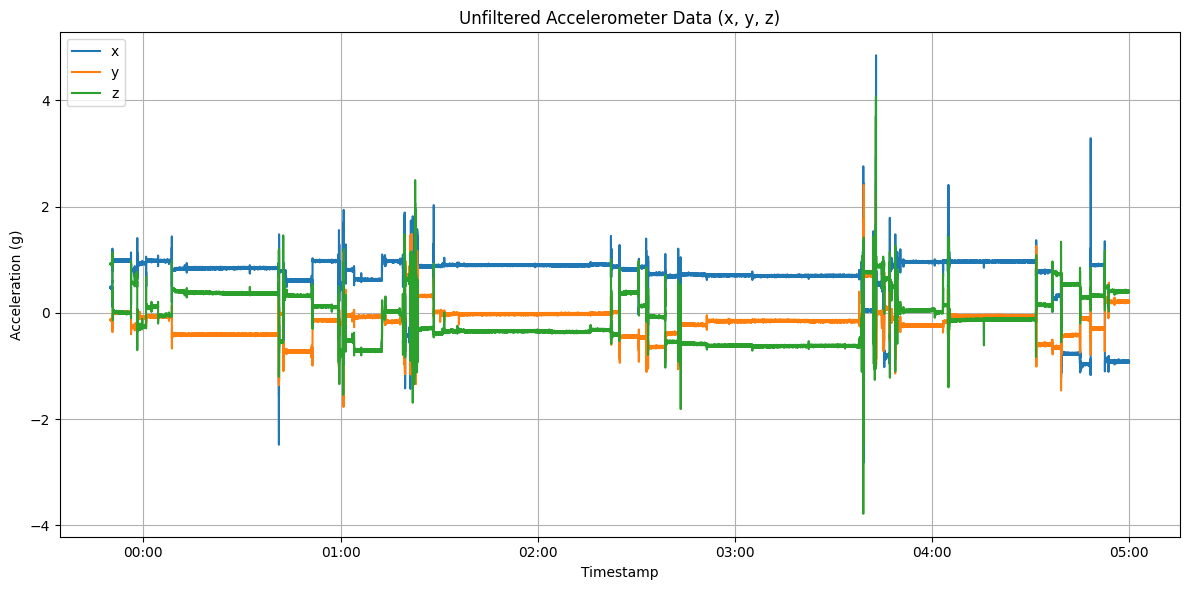

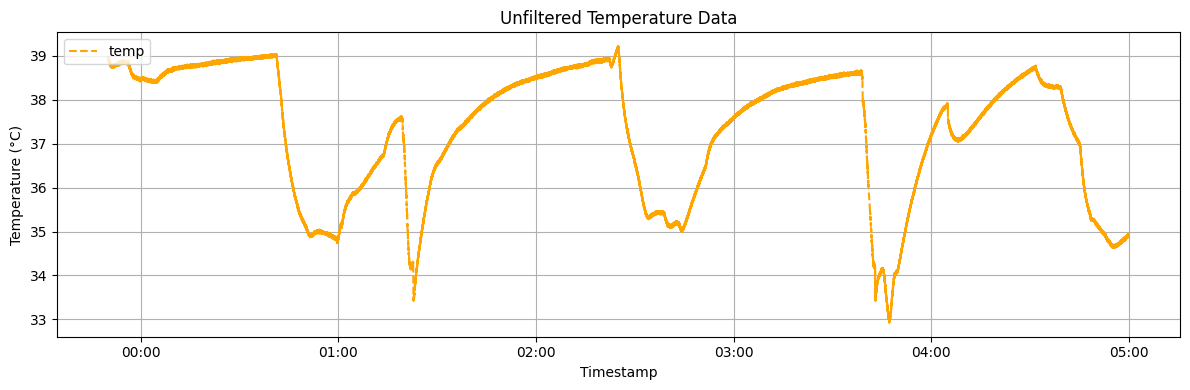

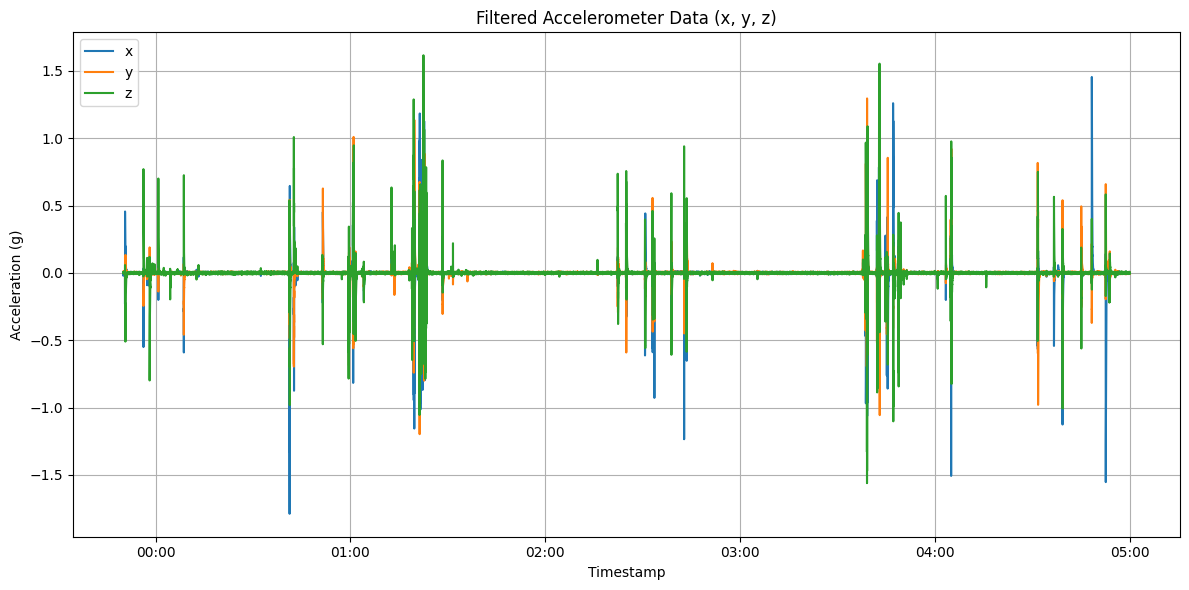

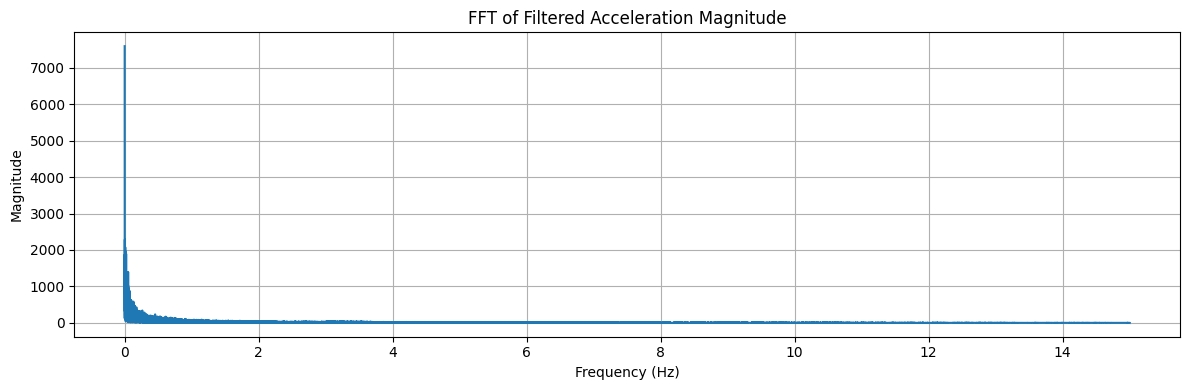

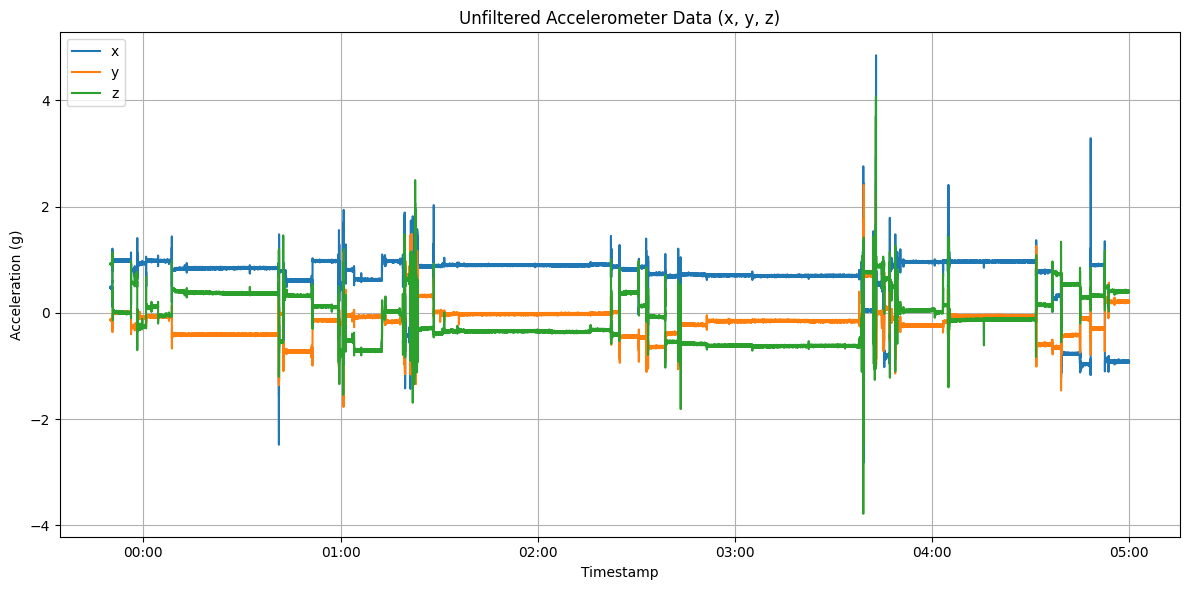

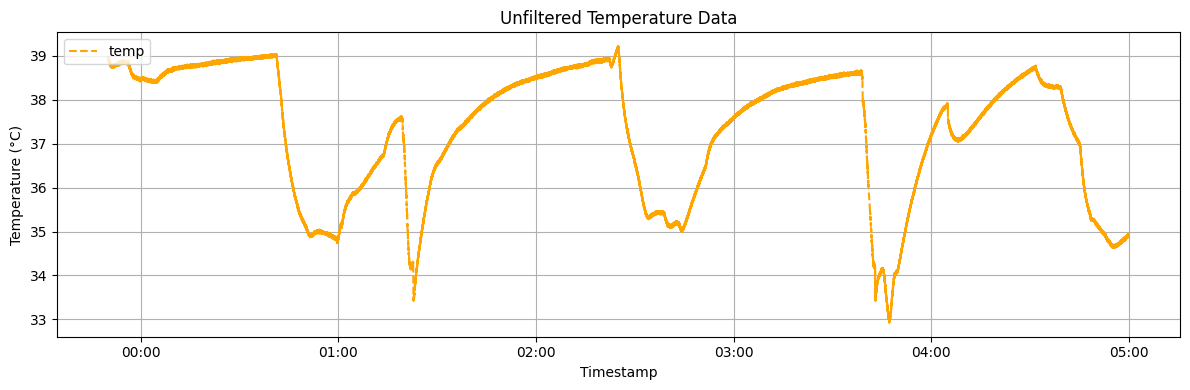

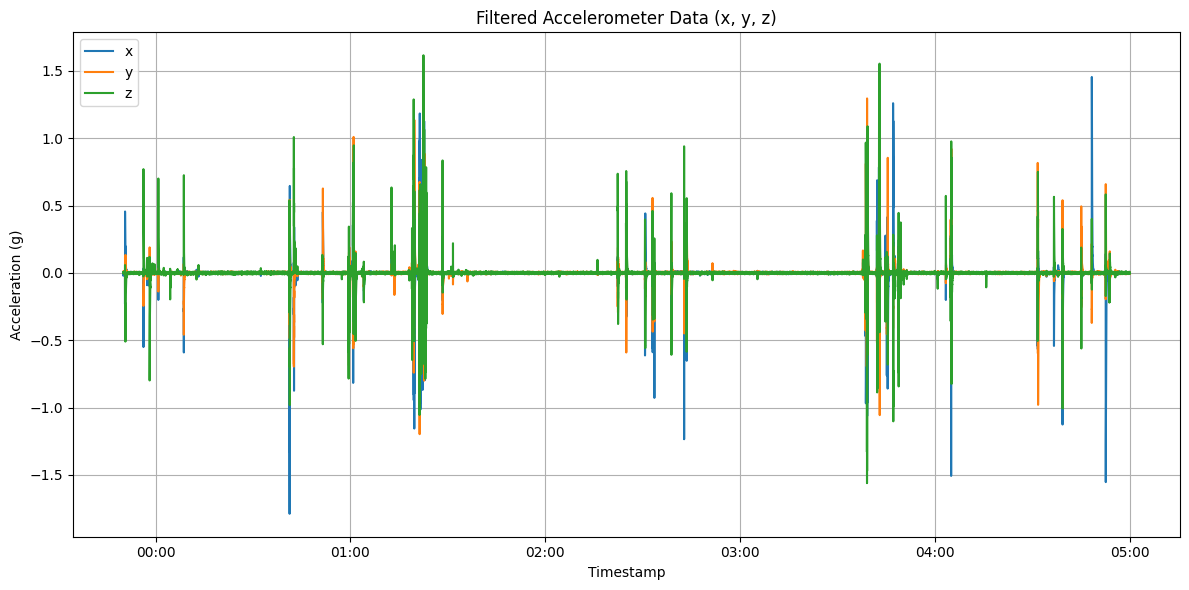

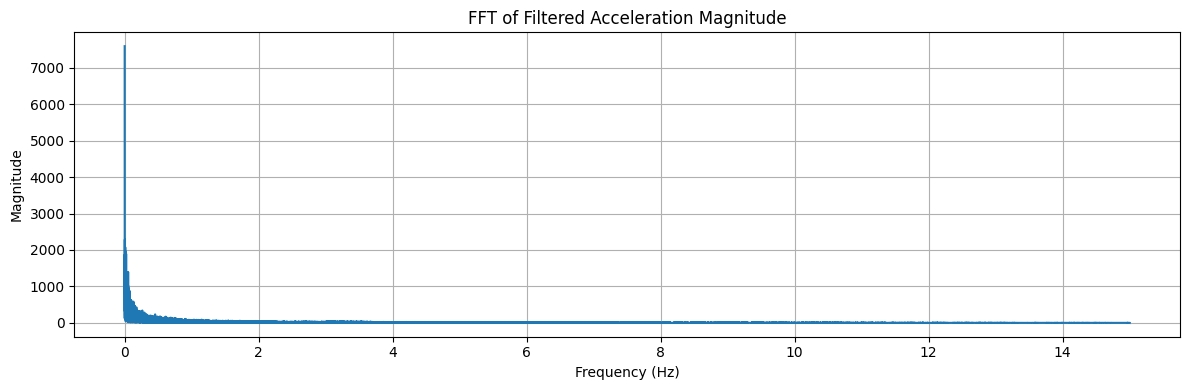

In [22]:
"""
CSV Analysis Tool – Jupyter/Python
---------------------------------
Reads every CSV inside a chosen folder, merges them **in-memory**, and plots all series:
  • `x`, `y`, `z` → first graph (range –1…1)
  • `temperature` → second graph (range  20…50 °C)
Tweak the *Parameters* section and run each cell top-to-bottom in Jupyter.
"""

# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal
from pathlib import Path
from IPython.display import display

# %% Parameters ——--------------------------
folder = Path('./data/session_20250621_2318')  # ← change me!
file_pattern = '*.csv'
timestamp_col = 'timestamp'
time_start = "23:50"  # format HH:MM
time_end = "05:00"    # format HH:MM
sampling_rate_hz = 30  # samples per second
lowpass_fc = 1.5       # Hz (adjusted for sleep detection)
highpass_fc = 0.05     # Hz (adjusted for sleep detection)

# %% Filter functions
# Low Pass Filter
def lpfParams(fc, fs):
    w0 = 2 * np.pi * fc
    num = w0
    den = [1, w0]
    tf = signal.TransferFunction(num, den)
    dt = 1.0 / fs
    result = tf.to_discrete(dt, method='gbt', alpha=0.5)
    b = result.num
    a = -result.den[1:]  # ignore a[0]
    return a, b

# High Pass Filter
def hpfParams(fc, fs):
    w0 = 2 * np.pi * fc
    num = [1, 0]
    den = [1, w0]
    tf = signal.TransferFunction(num, den)
    dt = 1.0 / fs
    result = tf.to_discrete(dt, method='gbt', alpha=0.5)
    b = result.num
    a = -result.den[1:]  # ignore a[0]
    return a, b

# Apply filter coefficients
def applyFilter(x, b, a):
    y = np.zeros(len(x))
    for i in range(2, len(x)):
        y[i] = a[0] * y[i-1] + b[0] * x[i] + b[1] * x[i-1]
    return y

# %% 1) Read & merge all CSVs in-memory
csv_files = sorted(folder.glob(file_pattern))
if not csv_files:
    raise FileNotFoundError(f'No CSV files matching {file_pattern} in {folder}')

frames = []
for f in csv_files:
    df = pd.read_csv(f)
    if df.columns[0] != timestamp_col:
        df.rename(columns={df.columns[0]: timestamp_col}, inplace=True)
    frames.append(df)
raw_data = pd.concat(frames, ignore_index=True)

# %% 2) Timestamp cleanup & ordering
raw_data[timestamp_col] = pd.to_datetime(raw_data[timestamp_col], unit='ms')
raw_data.sort_values(timestamp_col, inplace=True)
raw_data.reset_index(drop=True, inplace=True)

# %% 3) Optional: restrict to time window (e.g. 23:50 to 05:00)
def filter_by_timeframe(df, col, start, end):
    times = df[col].dt.time
    start_h, start_m = map(int, start.split(":"))
    end_h, end_m = map(int, end.split(":"))
    start_t = pd.to_datetime(f"{start_h:02}:{start_m:02}").time()
    end_t = pd.to_datetime(f"{end_h:02}:{end_m:02}").time()
    if start_t <= end_t:
        return df[(times >= start_t) & (times <= end_t)]
    else:
        return df[(times >= start_t) | (times <= end_t)]

if time_start and time_end:
    raw_data = filter_by_timeframe(raw_data, timestamp_col, time_start, time_end)

# %% 4) Backup original data for unfiltered plots
unfiltered_data = raw_data.copy()

# %% 5) Apply LPF + HPF to x/y/z
for col in ['x', 'y', 'z']:
    if col in raw_data.columns:
        a_hp, b_hp = hpfParams(highpass_fc, sampling_rate_hz)
        a_lp, b_lp = lpfParams(lowpass_fc, sampling_rate_hz)
        hp_filtered = applyFilter(raw_data[col].values, b_hp, a_hp)
        lp_filtered = applyFilter(hp_filtered, b_lp, a_lp)
        raw_data[col] = lp_filtered

# %% 6) Plot — unfiltered x, y, z
fig1, ax1 = plt.subplots(figsize=(12, 6))
y_axes_cols = ['x', 'y', 'z']
for col in y_axes_cols:
    if col in unfiltered_data.columns:
        ax1.plot(unfiltered_data[timestamp_col], unfiltered_data[col], label=col)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Acceleration (g)')
ax1.legend(loc='upper left')
ax1.set_title('Unfiltered Accelerometer Data (x, y, z)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(True)
fig1.tight_layout()
display(fig1)
_ = None

# %% 7) Plot — unfiltered temperature
if 'temp' in unfiltered_data.columns:
    fig2, ax2 = plt.subplots(figsize=(12, 4))
    ax2.plot(unfiltered_data[timestamp_col], unfiltered_data['temp'], linestyle='--', label='temp', color='orange')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Unfiltered Temperature Data')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.legend(loc='upper left')
    ax2.grid(True)
    fig2.tight_layout()
    display(fig2)
    _ = None

# %% 8) Plot — filtered x, y, z
fig3, ax3 = plt.subplots(figsize=(12, 6))
for col in y_axes_cols:
    if col in raw_data.columns:
        ax3.plot(raw_data[timestamp_col], raw_data[col], label=col)
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Acceleration (g)')
ax3.legend(loc='upper left')
ax3.set_title('Filtered Accelerometer Data (x, y, z)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.grid(True)
fig3.tight_layout()
display(fig3)
_ = None

# %% 9) Plot — FFT of filtered acceleration magnitude
acc = raw_data[['x', 'y', 'z']].dropna().values
mag = np.linalg.norm(acc, axis=1)
freqs = np.fft.fftfreq(len(mag), d=1.0/sampling_rate_hz)
spectrum = np.abs(np.fft.fft(mag))

fig4, ax4 = plt.subplots(figsize=(12, 4))
ax4.plot(freqs[:len(freqs)//2], spectrum[:len(freqs)//2])
ax4.set_title("FFT of Filtered Acceleration Magnitude")
ax4.set_xlabel("Frequency (Hz)")
ax4.set_ylabel("Magnitude")
ax4.grid(True)
fig4.tight_layout()
display(fig4)
_ = None